In [1]:
# dataset is from https://www.kaggle.com/sunnysai12345/news-summary
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

C:\Users\taimo\anaconda3\envs\test2\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\taimo\anaconda3\envs\test2\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\taimo\anaconda3\envs\test2\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Data

In [2]:
summary = pd.read_csv('./input/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('./input/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [4]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [5]:
print(pre.shape)
pre.head()

(102915, 2)


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


# Cleaning data

In [6]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))


In [7]:
pre['tokenized'] = pre['text'].astype(str).apply(apply_all) + pre['summary'].astype(str).apply(apply_all)

pre.shape

(102915, 3)

# Get word frequency

In [8]:
all_words=[word for item in list(pre["tokenized"]) for word in item]
fdist = FreqDist(all_words)
len(fdist) 


114948

In [9]:
fdist

FreqDist({'said': 66796, 'india': 28319, 'ad': 23155, 'year': 21631, 'also': 19622, 'us': 19254, 'report': 17485, 'polic': 16210, 'govern': 15916, 'indian': 15777, ...})

In [10]:
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('ayad', 2),
 ('allawi', 2),
 ('rimmel', 2),
 ('coti', 2),
 ('jargon', 2),
 ('mashoor', 2),
 ('flamengo', 2),
 ('nobleman', 2),
 ('unipol', 2),
 ('hirado', 2)]

In [11]:
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('manjit', 16),
 ('marlena', 16),
 ('comma', 16),
 ('ea', 16),
 ('garhwal', 16),
 ('amalraj', 16),
 ('jumpsuit', 16),
 ('decibel', 16),
 ('kodagu', 16),
 ('multi', 16)]

In [12]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [13]:
pre['tokenized'] = pre['tokenized'].apply(keep_top_k_words)

In [14]:
pre.shape

(102915, 3)

In [15]:
pre['doc_len'] = pre['tokenized'].apply(lambda x: len(x))
doc_lengths = list(pre['doc_len'])
pre.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 102915 
average document length 47.897459068163045 
minimum document length 2 
maximum document length 6405


# Drop short articles

In [16]:
pre = pre[pre['tokenized'].map(len) >= 40]

pre = pre[pre['tokenized'].map(type) == list]
pre.reset_index(drop=True,inplace=True)
pre.shape

(60291, 3)

In [17]:
pre.head()

,text,summary,tokenized
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,"[kant, alumnu, upgrad, pg, program, machin, le..."
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,"[kunal, shah, credit, card, bill, payment, pla..."
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,"[new, zealand, defeat, india, wicket, fourth, ..."
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,"[aegon, life, iterm, insur, plan, custom, enjo..."
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...","[speak, sexual, harass, alleg, rajkumar, hiran..."


In [82]:
train_df= pre

# LDA gensim version

In [83]:
num_topics = 30
chunksize = 200
dictionary = corpora.Dictionary(train_df['tokenized'])
corpus = [dictionary.doc2bow(doc) for doc in train_df['tokenized']]
t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-1, chunksize=chunksize, minimum_probability=0.0, passes=2)
t2 = time.time()
print("Time to train LDA model on ", len(train_df), "articles: ", (t2-t1)/60, "min")
 

Time to train LDA model on  60291 articles:  0.9814642707506815 min


In [104]:
for i in range(30):
    print("Topic {} : {}".format(i+1, [i for i in zip(*lda.show_topic(topicid=i, topn=10))][0]))

Topic 1 : ('year', 'india', 'pakistan', 'first', 'time', 'world', 'day', 'way', 'last', 'open')
Topic 2 : ('polic', 'delhi', 'case', 'arrest', 'woman', 'file', 'accus', 'offic', 'allegedli', 'alleg')
Topic 3 : ('crore', 'sinc', 'tax', 'year', 'launch', 'per', 'alreadi', 'compani', 'pay', 'list')
Topic 4 : ('women', 'know', 'seen', 'complet', 'tri', 'term', 'north', 'despit', 'didnt', 'tv')
Topic 5 : ('bodi', 'use', 'develop', 'demand', 'note', 'car', 'system', 'found', 'univers', 'also')
Topic 6 : ('said', 'issu', 'would', 'fight', 'within', 'countri', 'caus', 'process', 'must', 'notic')
Topic 7 : ('look', 'base', 'import', 'region', 'doctor', 'deal', 'strike', 'repres', 'brother', 'kind')
Topic 8 : ('could', 'need', 'chang', 'yet', 'whether', 'doesnt', 'affect', 'walk', 'aamir', 'rss')
Topic 9 : ('lakh', 'servic', 'power', 'govern', 'creat', 'bill', 'posit', 'also', 'appoint', 'provid')
Topic 10 : ('offici', 'report', 'said', 'incid', 'home', 'hous', 'ban', 'investig', 'protest', 'roa

In [135]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [136]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(60291, 30)

In [137]:
lda_keys = get_keys(doc_topic_dist)
lda_categories, lda_counts = keys_to_counts(lda_keys)

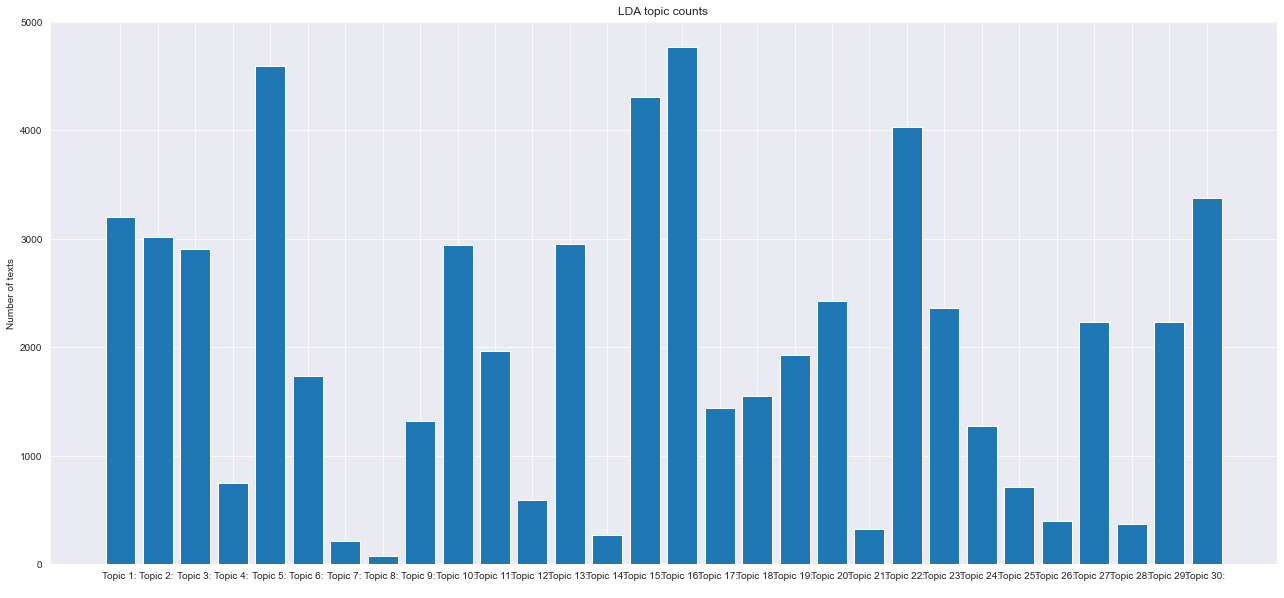

In [138]:

labels = ['Topic {}: \n'.format(i+1) for i in lda_categories]

fig, ax = plt.subplots(figsize=(22,10))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of texts');

# LDA sklearn vesion

In [139]:

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter

Loading BokehJS ...

In [140]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
text_sample = pd.Series(train_df["tokenized"].values)

print('text before vectorization: {}'.format(text_sample[123]))

document_term_matrix = count_vectorizer.fit_transform(text_sample.apply(lambda x : " ".join(x)))

print('text after vectorization: \n{}'.format(document_term_matrix[123]))

text before vectorization: ['incom', 'tax', 'depart', 'tuesday', 'said', 'confisc', 'asset', 'worth', 'crore', 'far', 'transact', 'law', 'abet', 'induc', 'benami', 'transact', 'beneficiari', 'may', 'face', 'rigor', 'imprison', 'year', 'besid', 'liabl', 'pay', 'fine', 'ad', 'tax', 'depart', 'start', 'initi', 'action', 'new', 'law', 'novemb', 'confisc', 'benami', 'asset', 'worth', 'crore', 'dept']
text after vectorization: 
  (0, 14737)	1
  (0, 8947)	1
  (0, 13141)	2
  (0, 11419)	1
  (0, 143)	1
  (0, 3360)	2
  (0, 14655)	2
  (0, 4411)	1
  (0, 2978)	2
  (0, 9120)	1
  (0, 13543)	2
  (0, 12608)	1
  (0, 13651)	1
  (0, 841)	2
  (0, 4608)	1
  (0, 6277)	1
  (0, 131)	1
  (0, 9691)	1
  (0, 6157)	1
  (0, 7358)	2
  (0, 2710)	2
  (0, 4468)	1
  (0, 47)	1
  (0, 6222)	1
  (0, 1327)	2
  (0, 1336)	1
  (0, 11156)	1
  (0, 6124)	1
  (0, 1359)	1
  (0, 7471)	1
  (0, 3377)	1


In [141]:
lda_model = LatentDirichletAllocation(n_components=30, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [142]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [143]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(30):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [144]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [145]:
top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  said polic sexual video accus yearold alleg boy man harass
Topic 2:  nasa said moon earth year mar space planet metro food
Topic 3:  india team win match cricket world indian cup seri play
Topic 4:  research said use studi scientist human develop year univers new
Topic 5:  bjp said parti cm congress minist pradesh singh state leader
Topic 6:  polic delhi said student arrest school case allegedli accus girl
Topic 7:  car musk tesla said elon vehicl gold compani polic spacex
Topic 8:  cricket test indian kohli india captain run team odi score
Topic 9:  china said india chines space launch govern indian year minist
Topic 10:  said india pakistan countri iran indian presid ad nuclear nation
Topic 11:  said tweet ad peopl say like user twitter dont want
Topic 12:  said armi kill attack forc kashmir polic indian secur terrorist
Topic 13:  compani startup said billion million fund ceo rais india report
Topic 14:  said chief offic parti govern delhi state leader minist cm
Topic 15:  

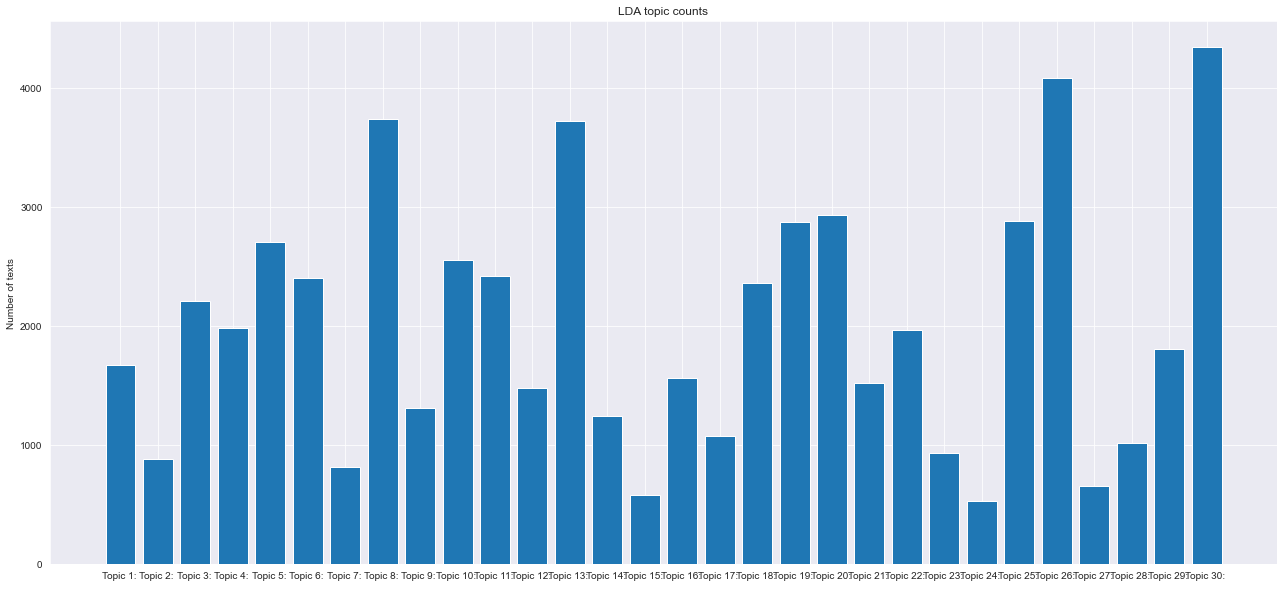

In [146]:

labels = ['Topic {}: \n'.format(i+1) for i in lda_categories]

fig, ax = plt.subplots(figsize=(22,10))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of texts');